In [49]:
import gc
gc.collect()

7042

In [2]:
# Import comet_ml at the top of your file
# from comet_ml import Experiment


from matplotlib import pyplot as plt
# from matplotlib import style
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import swifter
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import itertools
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from sklearn.model_selection import train_test_split
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras as k
import tensorflow as tf
# import torch
from scipy import stats
import nltk



# Create an experiment with your api key
# experiment = Experiment(
#     api_key="BKac2uRt0FMAlheXf6HClaZhD",
#     project_name="general",
#     workspace="sarthak7034",
# )


In [3]:
nltk.download('stopwords')
stop_words = stopwords.words('english') 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/s/sarthak_7034/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('gpu')))
# torch.cuda.is_available()

Num GPUs Available:  0


2022-04-07 12:31:34.048778: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [5]:
# # Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)


# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
    
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

In [222]:
# experiment.end()

In [6]:
#Read dataset
data = pd.read_csv("./all_data.csv").drop("Unnamed: 0", axis=1)

## Cleaning Text

In [7]:
# stop_words = stop_words.remove('not')
def clean_text(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    #Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    # remove stopwords
    tokens = [w for w in tokens if not w in stop_words]     # Experiment with removing it!!!
    #Remove non alphanumerica characters
    words = [word for word in tokens if word.isalpha()]    
    return words

scaler = MinMaxScaler()

In [8]:
#Applying lamdba function to clean text
data['text'] = data.swifter.apply(lambda row: clean_text(row['text']), axis=1)
#Clean title
data['title'] = data.swifter.apply(lambda row: clean_text(row['title']), axis=1)


Pandas Apply:   0%|          | 0/20015 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/20015 [00:00<?, ?it/s]

In [9]:
#Replacing row with only text
data = data[data['title'].str.len() >= 1]
data = data[data['text'].str.len() >= 1]

In [227]:
# df1 = data.loc[:,['anger','anticipation','disgust','fear','joy','sadness','surprise','trust','negative','positive']]

# # Zero Score Dataframe Normalization
# MaxMin_df = stats.zscore(df1)
# MaxMin_df.head()

In [10]:
#Displaying the new dataset which we will be working with
df2 = data.loc[:,['title','text','type']]

In [229]:
# Whether any values are missing
# df2.isnull().sum()
# df1.isnull().sum()

In [11]:
df2 = df2[df2['text'].map(len) >= 1]
#Reset index
df2 = df2.reset_index().drop("index", axis=1)
df2


,title,text,type
0,"[At, Donald, Trump, Properties, Showcase, Bran...","[They, stood, line, Trump, Tower, sometimes, h...",real
1,"[Trump, Foundation, Tells, New, York, It, Has,...","[Donald, J, Trump, foundation, informed, Attor...",real
2,"[Donald, Trump, Prepares, White, House, Move, ...","[President, Donald, J, Trump, White, House, ou...",real
3,"[Luring, Chinese, Investors, With, Trump, Name...","[An, investment, pitch, new, Texas, hotel, try...",real
4,"[Melania, Barron, Trump, Won, Immediately, Mov...","[President, Donald, J, Trump, wife, Melania, s...",real
...,...,...,...
19800,"[Alabama, Lawmaker, Same, Couples, Don, Deserv...","[Most, conservatives, oppose, marriage, equali...",real
19801,"[GOP, Senator, David, Perdue, Jokes, About, Pr...","[The, freshman, senator, Georgia, quoted, scri...",real
19802,"[State, Department, says, find, emails, Clinto...","[The, State, Department, told, Republican, Nat...",real
19803,"[In, Ethiopia, Obama, seeks, progress, peace, ...","[ADDIS, ABABA, Ethiopia, Obama, convened, meet...",real


type
fake    11731
real     8074
Name: title, dtype: int64


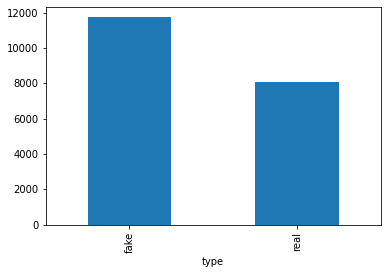

In [12]:
# How many fake and real articles?
print(df2.groupby(['type'])['title'].count())
df2.groupby(['type'])['title'].count().plot(kind="bar")
plt.show()

## Word2Vec

In [14]:
model_embed = KeyedVectors.load_word2vec_format("./GoogleNews-vectors-negative300.bin.gz",binary=True)

In [15]:
vocab_length = len(model_embed.key_to_index.keys())
print(vocab_length)                                         #Input dimension size(3000000)

3000000


In [16]:
# Applying it to the columns 

df2['title'] = df2.swifter.apply(lambda r: [model_embed.key_to_index[x] for x in r['title'] if x in model_embed.key_to_index], axis=1)
df2['text'] = df2.swifter.apply(lambda r: [model_embed.key_to_index[x] for x in r['text'] if x in model_embed.key_to_index], axis=1)

Pandas Apply:   0%|          | 0/19805 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/19805 [00:00<?, ?it/s]

In [17]:
# # One-hot encoding
# encoder = LabelBinarizer().fit(list(df2['type']))
# df2['type'] = df2.swifter.apply(lambda r: encoder.transform([r['type']])[0], axis=1)

variable_name = {'fake' : 0 , 'real' : 1 }
df2['type'] = df2['type'].map(variable_name)

In [18]:
df2 = df2[df2['text'].map(len) >= 1]
#Reset index
df2 = df2.reset_index().drop("index", axis=1)
df2

,title,text,type
0,"[332, 6117, 13034, 11062, 20257, 9193, 446]","[128, 2379, 318, 13034, 9413, 1631, 242, 957, ...",1
1,"[13034, 2124, 44625, 442, 5353, 51, 7754, 8808...","[6117, 4883, 13034, 3113, 2826, 4605, 1927, 33...",1
2,"[6117, 13034, 49031, 1790, 659, 11977, 553, 94...","[446, 6117, 4883, 13034, 1790, 659, 16780, 177...",1
3,"[176192, 1035, 3789, 316, 13034, 12441, 3337, ...","[741, 615, 1924, 65, 675, 1639, 469, 8793, 112...",1
4,"[282726, 14896, 13034, 26994, 17785, 11977, 17...","[446, 6117, 4883, 13034, 783, 282726, 831, 148...",1
...,...,...,...
19667,"[2625, 47190, 14968, 22328, 4119, 115896, 1496...","[1214, 6555, 5472, 2724, 10729, 12687, 6484, 3...",1
19668,"[2751, 4301, 689, 19370, 82238, 1523, 94624, 4...","[7, 2779, 4264, 1742, 2717, 38413, 168, 1956, ...",1
19669,"[268, 423, 115, 359, 9451, 1820, 1735, 3803]","[7, 268, 423, 162, 917, 430, 1468, 75, 359, 94...",1
19670,"[70, 9711, 494, 3786, 1463, 1356, 371, 1063, 1...","[1538939, 1151610, 9711, 494, 13595, 349, 618,...",1


In [19]:
# Shifting all to a new dataframe
df3 = df2.loc[:,['title','text','type']]

In [20]:
# Check the highest length of text and title:
max_tokens_text = 13000
max_tokens_title = 48

## Padding

In [21]:
df3['text'] = list(pad_sequences((df2['text']), maxlen=max_tokens_text,padding='post'))
df3['title'] = list(pad_sequences(df2['title'], maxlen=max_tokens_title,padding='post'))

In [22]:
#Python object serialized
df3.to_pickle('./model_data.pickle')

# Building Model

## Loading Pickle 

In [23]:
data_pickle = pd.read_pickle('./model_data.pickle')
data_pickle = data_pickle.dropna()


In [24]:
#Train - test
X_train, X_test, y_train, y_test = train_test_split(
    data_pickle[['text', 'title']], data_pickle['type'], test_size=0.2, random_state=42)

#Train - valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)
 

train_fit = [np.asarray(X_train['title'].tolist()), 
             np.asarray(X_train['text'].tolist())
             ]

valid_fit = [np.asarray(X_valid['title'].tolist()), 
             np.asarray(X_valid['text'].tolist())
             ]

test_fit = [np.asarray(X_test['title'].tolist()), 
             np.asarray(X_test['text'].tolist())
             ]    




## Binary_crossentropy

In [25]:
from numpy.random import seed

seed(50)
tf.random.set_seed(50)
k.backend.clear_session()

In [26]:
#input_title
title_input = k.layers.Input(shape=(max_tokens_title,))
inp1 = k.layers.Embedding(input_dim=3000000,output_dim=300,trainable=False)(title_input)

#Added
x1 = k.layers.Conv1D(filters = 5, kernel_size=4, strides=2, activation='relu')(inp1)
x1 = k.layers.MaxPool1D(pool_size = 2, name='Pool1Title')(x1)
x1 = k.layers.Flatten()(x1)
x1 = k.layers.Dense(50, activation='relu', name='Dense1Title', kernel_regularizer='l2')(x1)

#input_Text
text_input = k.layers.Input(shape=(max_tokens_text,))
inp2 = k.layers.Embedding(input_dim=3000000,output_dim=300,trainable=False)(text_input)

x2 = k.layers.Conv1D(filters = 40, kernel_size = 16, strides = 2, activation='relu')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4)(x2)

#Added
x2 = k.layers.Conv1D(filters = 80, kernel_size = 16, strides = 4, activation='relu')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4)(x2)
x2 = k.layers.Flatten()(x2)
x2 = k.layers.Dense(100, activation='relu', kernel_regularizer='l2', name='Dense1Text')(x2)


#Merge
x = k.layers.concatenate([x1, x2])

#Common part
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
out = k.layers.Dense(1, activation='sigmoid')(x)


#Build model
model = k.models.Model(inputs=[title_input, text_input], outputs=[out])

model.compile(k.optimizers.RMSprop(), loss='binary_crossentropy', metrics=['acc'])

model.summary()

2022-04-07 12:34:53.457829: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-07 12:34:53.486047: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 13000)]      0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 48, 300)      900000000   input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 13000, 300)   900000000   input_2[0][0]                    
______________________________________________________________________________________________

## Fitting the Model

In [27]:
history = model.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=128, epochs=20,
        callbacks = [k.callbacks.EarlyStopping(monitor='val_loss', patience=4)], 
        validation_data=(valid_fit, np.array(y_valid.tolist())))

2022-04-07 12:35:00.581643: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-07 12:35:00.638737: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


Epoch 1/20
99/99 [==============================] - 213s 2s/step - loss: 1.3123 - acc: 0.6497 - val_loss: 0.6286 - val_acc: 0.7840
Epoch 2/20
99/99 [==============================] - 197s 2s/step - loss: 0.5163 - acc: 0.8536 - val_loss: 0.4146 - val_acc: 0.8707
Epoch 3/20
99/99 [==============================] - 199s 2s/step - loss: 0.4398 - acc: 0.8866 - val_loss: 0.4718 - val_acc: 0.8475
Epoch 4/20
99/99 [==============================] - 199s 2s/step - loss: 0.2648 - acc: 0.9406 - val_loss: 0.3819 - val_acc: 0.8882
Epoch 5/20
99/99 [==============================] - 199s 2s/step - loss: 0.2597 - acc: 0.9620 - val_loss: 0.3604 - val_acc: 0.8961
Epoch 6/20
99/99 [==============================] - 198s 2s/step - loss: 0.1512 - acc: 0.9818 - val_loss: 0.4138 - val_acc: 0.8949
Epoch 7/20
99/99 [==============================] - 196s 2s/step - loss: 0.1600 - acc: 0.9817 - val_loss: 0.3551 - val_acc: 0.9041
Epoch 8/20
99/99 [==============================] - 184s 2s/step - loss: 0.1234 - a

In [246]:
test_pred = model.predict(test_fit)

In [247]:
report = classification_report(np.array(y_test.tolist()), test_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2354
           1       0.88      0.88      0.88      1581

    accuracy                           0.91      3935
   macro avg       0.90      0.90      0.90      3935
weighted avg       0.91      0.91      0.91      3935



## Categorical_crossentropy

In [28]:
from numpy.random import seed

seed(50)
tf.random.set_seed(50)
k.backend.clear_session()

In [35]:
#input_title
title_input = k.layers.Input(shape=(max_tokens_title,))
inp1 = k.layers.Embedding(input_dim=3000000,output_dim=300,trainable=False)(title_input)

x = k.layers.Conv1D(filters = 5, kernel_size=4, strides=2, activation='relu')(inp1)
x = k.layers.MaxPool1D(pool_size = 2)(x)
x = k.layers.Flatten()(x)
x = k.layers.Dense(50, activation='relu',  kernel_regularizer='l2')(x)

#input_content
text_input = k.layers.Input(shape=(max_tokens_text,))
inp2 = k.layers.Embedding(input_dim=3000000,output_dim=300,trainable=False)(text_input)

x2 = k.layers.Conv1D(filters = 40, kernel_size = 16, strides = 2, activation='relu')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4 )(x2)

#Added
x2 = k.layers.Conv1D(filters = 80, kernel_size = 16, strides = 4, activation='relu')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4, )(x2)
x2 = k.layers.Flatten()(x2)
x2 = k.layers.Dense(100, activation='relu', kernel_regularizer='l2')(x2)


#Merge
x = k.layers.concatenate([x, x2])

#Common part
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
out = k.layers.Dense(4, activation='softmax')(x)


#Build model
model = k.models.Model(inputs=[title_input, text_input], outputs=[out])

model.compile(k.optimizers.RMSprop(), loss='sparse_categorical_crossentropy', metrics=['acc'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 48)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 13000)]      0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 48, 300)      900000000   input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 13000, 300)   900000000   input_4[0][0]                    
____________________________________________________________________________________________

## Fitting the Model

In [36]:
history = model.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=128, epochs=30,
        callbacks = [k.callbacks.EarlyStopping(monitor='val_loss', patience=4)], 
        validation_data=(valid_fit, np.array(y_valid.tolist())))

Epoch 1/30
99/99 [==============================] - 196s 2s/step - loss: 2.2311 - acc: 0.5749 - val_loss: 0.6273 - val_acc: 0.8005
Epoch 2/30
99/99 [==============================] - 189s 2s/step - loss: 0.5854 - acc: 0.8133 - val_loss: 0.4450 - val_acc: 0.8529
Epoch 3/30
99/99 [==============================] - 185s 2s/step - loss: 0.4715 - acc: 0.8577 - val_loss: 0.4134 - val_acc: 0.8631
Epoch 4/30
99/99 [==============================] - 188s 2s/step - loss: 0.3112 - acc: 0.9219 - val_loss: 0.3519 - val_acc: 0.8907
Epoch 5/30
99/99 [==============================] - 183s 2s/step - loss: 0.2213 - acc: 0.9561 - val_loss: 0.3918 - val_acc: 0.8914
Epoch 6/30
99/99 [==============================] - 185s 2s/step - loss: 0.1774 - acc: 0.9724 - val_loss: 0.3862 - val_acc: 0.8990
Epoch 7/30
99/99 [==============================] - 184s 2s/step - loss: 0.1466 - acc: 0.9801 - val_loss: 0.4242 - val_acc: 0.8923
Epoch 8/30
99/99 [==============================] - 188s 2s/step - loss: 0.1500 - a

In [37]:
test_pred = model.predict(test_fit)

In [47]:
# get predicted indices (ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets)
test_pred = np.argmax(test_pred, 1)

In [48]:
report = classification_report(np.array(y_test.tolist()), test_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2354
           1       0.88      0.88      0.88      1581

    accuracy                           0.90      3935
   macro avg       0.90      0.90      0.90      3935
weighted avg       0.90      0.90      0.90      3935

